# Convert dataset to YOLOv5 Format

In this notebook, I go over the process for manipulating the SKU110K dataset created by Eran Goldman et al., as part of their work "Precise Detection in Densely Packed Scenes" published at CVPR 2019. The goal is to:

- Format the annotations for use with the [`YOLOv5`](https://github.com/ultralytics/yolov5) single-stage object detector model
- Remove corrupted images and "fix" all other for use in training and testing ML models

For more details about the dataset itself, please visit the original Dataset and Codebase repository (linked in the `README.md` file of this repository).

The notebook will run both locally as well as in Google Colab, and all the steps needed for either platform are provided.

---
**Author:** Cisco Zabala ([@datasith](https://twitter.com/datasith) | [LinkedIn](https://www.linkedin.com/in/datasith/) | [Kaggle](https://kaggle.com/thedatasith) | [GitHub](https://github.com/datasith))

## Download and extract the SKU110K dataset

The location of the download will vary by users' preference. Although this can be done in multiple ways, preserving the download step in this notebook helps to keep track of the URL where to find the dataset. Lastly, depending on the system, either `wget` or `curl` might be preferred.

In [1]:
# sku_dataset_folder  = # 'Path to directory where the images were downloaded'
sku_dataset_folder  = '/Users/datasith/Downloads/'

# !wget http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz -P "$sku_dataset_folder"
!curl http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz --create-dirs -O --output-dir "$sku_dataset_folder"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.3G  100 11.3G    0     0  22.8M      0  0:08:29  0:08:29 --:--:-- 22.4M0:22  0:07:19 25.9M7 23.5M0:00:32  0:07:10 26.1MM      0  0:07:31  0:00:42  0:06:49 28.1M44 28.7M 0  0:07:42  0:00:58  0:06:44 20.0M0:07:52  0:01:06  0:06:46 21.1M.0M      0  0:07:43  0:01:26  0:06:17 25.1M2M      0  0:07:40  0:01:49  0:05:51 27.2M   0  0:08:07  0:02:04  0:06:03 13.6M6M      0  0:08:12  0:02:27  0:05:45 19.7M     0  0:08:13  0:02:33  0:05:40 21.9M  0:08:14  0:02:38  0:05:36 22.7M.5M      0  0:08:14  0:02:42  0:05:32 23.3M4  0:02:44  0:05:30 23.1M 23.9M      0  0:08:06  0:03:14  0:04:52 26.2M   0  0:08:06  0:03:36  0:04:30 22.9M  0  23.8M      0  0:08:07  0:04:00  0:04:07 22.5M 0:08:08  0:04:16  0:03:52 23.6M     0  0:08:08  0:04:25  0:03:43 24.0M      0  0:08:13  0:04:37  0:03:36 17.8M  0:03:15 21.7M      0  0:08:19  0:05:18  0:03:01 20.

In [2]:
!tar -xf "$sku_dataset_folder"/SKU110K_fixed.tar.gz -C "$sku_dataset_folder" > /dev/null

## Import necessary libraries

In [3]:
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import shutil
from pathlib import Path

## Set up the dataset's local path

In [4]:
sku_dataset_dirname = 'SKU110K_fixed'
path_images         = Path(sku_dataset_folder) / sku_dataset_dirname / 'images'
path_annotations    = Path(sku_dataset_folder) / sku_dataset_dirname / 'annotations'

In [5]:
# Sanity check
# !ls $path_images

## Re-organize files into test, train, and validation 

In [6]:
prefix_to_channel = {
    "train": "train",
    "val": "validation",
    "test": "test",
}

assert path_images.exists(), f"{path_images} not found"

for channel_name in prefix_to_channel.values():
    if not (path_images.parent / channel_name).exists():
        (path_images.parent / channel_name).mkdir()

for path_img in path_images.iterdir():
    for prefix in prefix_to_channel:
        if path_img.name.startswith(prefix):
            path_img.replace(
                path_images.parent / prefix_to_channel[prefix] / path_img.name
            )

## Remove corrupted files

In [7]:
# Revised list (54 images) courtesy of ankandrew on GitHub:
# https://github.com/eg4000/SKU110K_CVPR19/issues/99#issuecomment-988886374
CORRUPTED_IMAGES = {
    "train": (
              "train_1239.jpg",
              "train_2376.jpg",
              "train_2903.jpg",
              "train_2986.jpg",
              "train_305.jpg",
              "train_3240.jpg",
              "train_340.jpg",
              "train_3556.jpg",
              "train_3560.jpg",
              "train_3832.jpg",
              "train_38.jpg",
              "train_4222.jpg",
              "train_5007.jpg",
              "train_5137.jpg",
              "train_5143.jpg",
              "train_5762.jpg",
              "train_5822.jpg",
              "train_6052.jpg",
              "train_6090.jpg",
              "train_6138.jpg",
              "train_6409.jpg",
              "train_6722.jpg",
              "train_6788.jpg",
              "train_737.jpg",
              "train_7576.jpg",
              "train_7622.jpg",
              "train_775.jpg",
              "train_7883.jpg",
              "train_789.jpg",
              "train_8020.jpg",
              "train_8146.jpg",
              "train_882.jpg",
              "train_903.jpg",
              "train_924.jpg"
             ),
    "validation": (
              "val_147.jpg",
              "val_286.jpg",
              "val_296.jpg",
              "val_386.jpg"
             ),
    "test": (
              "test_132.jpg",
              "test_1346.jpg",
              "test_184.jpg",
              "test_1929.jpg",
              "test_2028.jpg",
              "test_22.jpg",
              "test_2321.jpg",
              "test_232.jpg",
              "test_2613.jpg",
              "test_2643.jpg",
              "test_274.jpg",
              "test_2878.jpg",
              "test_521.jpg",
              "test_853.jpg",
              "test_910.jpg",
              "test_923.jpg"
             ),             
}

In [8]:
for channel_name in prefix_to_channel.values():
    for img_name in CORRUPTED_IMAGES[channel_name]:
        try:
            (path_images.parent / channel_name / img_name).unlink()
            print(f"{img_name} removed from channel {channel_name} ")
        except FileNotFoundError:
            print(f"{img_name} not in channel {channel_name}")

train_1239.jpg removed from channel train 
train_2376.jpg removed from channel train 
train_2903.jpg removed from channel train 
train_2986.jpg removed from channel train 
train_305.jpg removed from channel train 
train_3240.jpg removed from channel train 
train_340.jpg removed from channel train 
train_3556.jpg removed from channel train 
train_3560.jpg removed from channel train 
train_3832.jpg removed from channel train 
train_38.jpg removed from channel train 
train_4222.jpg removed from channel train 
train_5007.jpg removed from channel train 
train_5137.jpg removed from channel train 
train_5143.jpg removed from channel train 
train_5762.jpg removed from channel train 
train_5822.jpg removed from channel train 
train_6052.jpg removed from channel train 
train_6090.jpg removed from channel train 
train_6138.jpg removed from channel train 
train_6409.jpg removed from channel train 
train_6722.jpg removed from channel train 
train_6788.jpg removed from channel train 
train_737.jpg r

In [9]:
# Expected output:
# Number of train images = 8185
# Number of validation images = 584
# Number of test images = 2919
for channel_name in prefix_to_channel.values():
    print(
        f"Number of {channel_name} images = {sum(1 for x in (path_images.parent / channel_name).glob('*.jpg'))}"
    )

Number of train images = 8185
Number of validation images = 584
Number of test images = 2920


In [10]:
os.rmdir(path_images)

## Reformat label (annotations) data

In [11]:
yolov5_dataset_folder = os.getcwd()
yolov5_sku_dataset_dirname = 'SKU110K_fixed'
local_path_annotations = Path(yolov5_dataset_folder) / yolov5_sku_dataset_dirname / 'labels'
local_path_images = Path(yolov5_dataset_folder) / yolov5_sku_dataset_dirname / 'images'

In [12]:
!mkdir -p $local_path_annotations $local_path_images

The original format of the `SKU110K` dataset is:

`'image', 'x1', 'y1', 'x2', 'y2', 'class', 'image_width', 'image_height'`

We need to convert it to `YOLO` format, which is:
- One row per object
- Each row is `class` &nbsp; `x_center` &nbsp; `y_center` &nbsp; `width` &nbsp; `height` format
- Box coordinates must be in **normalized xywh** format (from 0 - 1). If your boxes are in pixels:
    - Divide `x_center` and `width` by image width
    - Divive `y_center` and `height` by image height
- Class numbers are zero-indexed (start from 0)

In [13]:
names = 'image', 'x1', 'y1', 'x2', 'y2', 'class', 'image_width', 'image_height'
annotation_files =  path_annotations.glob('*.csv')

import sys

for file in annotation_files:
    print(file)
    data = pd.read_csv(file, names=names)  # annotations
    prefix = file.name.split('_')[-1].replace('.csv','')
    out_labels_dir = local_path_annotations / prefix
    out_images_dir = local_path_images / prefix

    isExist = os.path.exists(out_labels_dir)
    if not isExist:
        os.mkdir(out_labels_dir)

    isExist = os.path.exists(out_images_dir)
    if not isExist:
        os.mkdir(out_images_dir)
        
    for filename_img in data['image'].unique():
        # Get all bounding boxes for this image
        mask_filename_img = data['image'] == filename_img
        data_img = data[mask_filename_img].copy().reset_index()

        # Reformat each bounding box and add it to output file
        # YOLO format is normalized (img_width, img_height) = (1, 1)
        # NOTE: there are several erroneous annotations. Please see: 
        # https://github.com/eg4000/SKU110K_CVPR19/issues
        # for details.
        # 
        # I noticed a quite a few bounding boxes exceeding the boundaries
        # of the image. Ideally I should do something more sophisticated, 
        # but per eye inspection, the differences were "negligible". In 
        # order to be able to use the infringing image/annotation pairs 
        # when training a YOLOv5 model (which checks the normalization 
        # range to be [0,1]), I'm simply clipping to an upper bound of 1.
        im_width = data_img.image_width[0]
        im_height = data_img.image_height[0]

        data_img['width'] = data_img['x2'] - data_img['x1']
        data_img['height'] = data_img['y2'] - data_img['y1']
        data_img['xc'] = data_img['x1'] + data_img['width']/2
        data_img['yc'] = data_img['y1'] + data_img['height']/2
        
        data_img['xc'] = data_img['xc'] / im_width
        data_img['yc'] = data_img['yc'] / im_height
        data_img['width'] = data_img['width'] / im_width
        data_img['height'] = data_img['height'] / im_height


        data_img['xc'] = data_img['xc'].where(data_img['xc'] <= 1., 1.) 
        data_img['yc'] = data_img['yc'].where(data_img['yc'] <= 1., 1.) 
        data_img['width'] = data_img['width'].where(data_img['width'] <= 1., 1.) 
        data_img['height'] = data_img['height'].where(data_img['height'] <= 1., 1.) 
        data_img['class'] = 0
        
        data_img = data_img[['class','xc','yc','width','height']]

        # Set up the necessary paths
        filename_label = filename_img.replace('jpg','txt')
        out_labels_file = out_labels_dir / filename_label
        in_images_file = path_images.parent / prefix_to_channel[prefix] / filename_img
        out_images_file = out_images_dir / filename_img

        try:
            _ = shutil.copy2(in_images_file, out_images_file)
        except:
            # Exceptions are due to image file not existing for the corresponding label
            # raise NameError('check the image file name')
            print(f'check the image file name {filename_img}') 
            continue

        # If the image file is found and copied, it's safe to generate the corresponding label file
        data_img.to_csv(out_labels_file , sep=' ', header=False, index=False)

/Users/datasith/Downloads/SKU110K_fixed/annotations/annotations_test.csv
check the image file name test_132.jpg
check the image file name test_1346.jpg
check the image file name test_184.jpg
check the image file name test_1929.jpg
check the image file name test_2028.jpg
check the image file name test_22.jpg
check the image file name test_232.jpg
check the image file name test_2321.jpg
check the image file name test_2613.jpg
check the image file name test_2643.jpg
check the image file name test_274.jpg
check the image file name test_2878.jpg
check the image file name test_521.jpg
check the image file name test_853.jpg
check the image file name test_910.jpg
check the image file name test_923.jpg
/Users/datasith/Downloads/SKU110K_fixed/annotations/annotations_val.csv
check the image file name val_147.jpg
check the image file name val_286.jpg
check the image file name val_296.jpg
check the image file name val_386.jpg
/Users/datasith/Downloads/SKU110K_fixed/annotations/annotations_train.csv

### Fix corrupted (usable) image files

The `yolov5` implementation checks for corrupted images using the code below. Instead of having this occur at training or validation time, let's do it when preparing the dataset.

In [14]:
from PIL import ExifTags, Image, ImageOps

# Include image suffixes
IMG_FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp'  

# Get orientation exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break  

def exif_size(img):  
    # Returns exif-corrected PIL size
    s = img.size  # (width, height)
    try:
        rotation = dict(img._getexif().items())[orientation]
        if rotation == 6:  # rotation 270
            s = (s[1], s[0])
        elif rotation == 8:  # rotation 90
            s = (s[1], s[0])
    except:
        pass
    return s

for prefix in prefix_to_channel:
    _path = local_path_images / prefix / '*'
    local_files_images = glob.glob(_path.as_posix())
    for idx in range(0, len(local_files_images)):
        im_file = local_files_images[idx]
        im = Image.open(im_file) 
        im.verify()  # PIL verify 
        shape = exif_size(im)  # image size 
        assert (shape[0] > 9) & (shape[1] > 9), f'image size {shape} <10 pixels' 
        assert im.format.lower() in IMG_FORMATS, f'invalid image format {im.format}' 
        if im.format.lower() in ('jpg', 'jpeg'): 
            with open(im_file, 'rb') as f: 
                f.seek(-2, 2) 
                if f.read() != b'\xff\xd9':  # corrupt JPEG 
                    ImageOps.exif_transpose(Image.open(im_file)).save(im_file, 'JPEG', subsampling=0, quality=100) 
                    msg = f'{prefix}WARNING: {im_file}: corrupt JPEG restored and saved' 
                    print(msg)


## Visualize saved annotations

/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/train/train_2886.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/train/train_2886.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/train/train_3727.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/train/train_3727.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/train/train_3703.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/train/train_3703.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/val/val_19.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/val/val_19.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/val/val_475.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/val/val_475.txt
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/images/val/val_473.jpg
/Users/datasith/Work/ds-datasets-sku110k/SKU110K_fixed/labels/val/val_473.txt
/Users/datasith/Work/ds-datasets-sku

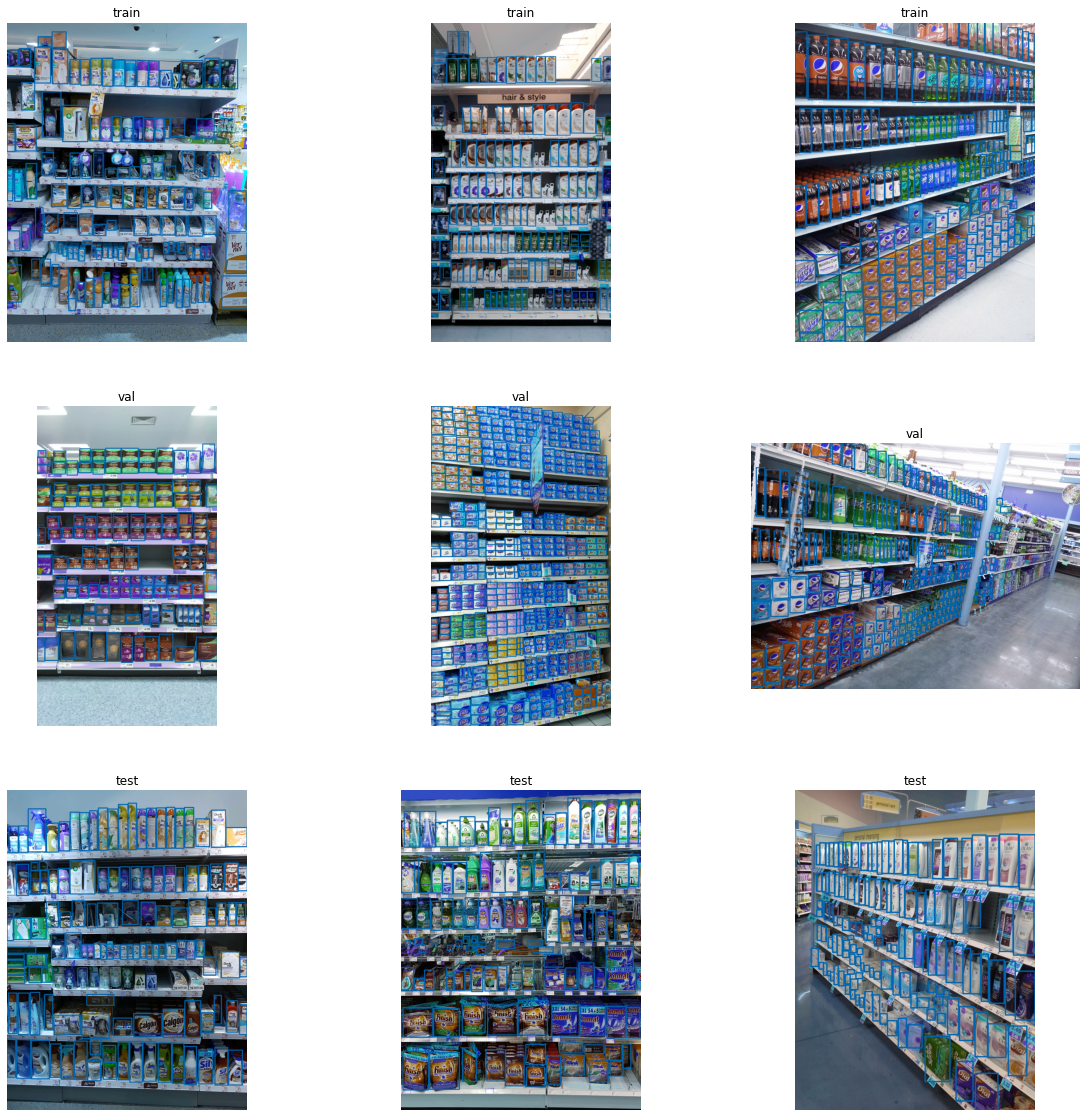

In [15]:
counter = 1
plt.figure(figsize=(20, 20), facecolor='white')

for prefix in prefix_to_channel:
    _path = local_path_images / prefix / '*'
    local_files_images = glob.glob(_path.as_posix())
    for idx in random.sample(range(0, len(local_files_images)), 3):
        filename_image = local_files_images[idx]
        filename_label = filename_image.replace('images','labels').replace('jpg','txt')
        data = pd.read_csv(filename_label, header=None, delimiter=' ')
        
        print(filename_image)
        print(filename_label)
        im = cv2.imread(filename_image)
        im_size = im.shape[:2]
        for _, bbox in data.iterrows():
            cls, xc, yc, w, h = bbox
            xmin = xc - w/2
            ymin = yc - h/2
            xmax = xc + w/2
            ymax = yc + h/2

            xmin *= im_size[1]
            ymin *= im_size[0]
            xmax *= im_size[1]
            ymax *= im_size[0]

            start_point = (int(xmin), int(ymin))
            end_point = (int(xmax), int(ymax))
            color = (0, 100, 175)
            thickness = 10

            im = cv2.rectangle(im, start_point, end_point, color, thickness)

        ax = plt.subplot(3, 3, counter)
        plt.title(prefix)
        plt.axis("off")
        plt.imshow(im)
        counter += 1